## **Settings**

- Importazione delle librerie necessarie e impostazione dei percorsi.

In [1]:
# Importazione delle librerie necessarie
import os
import sys
import random
from sys import platform

# Impostazione dei percorsi
_base_path = '\\'.join(os.getcwd().split('\\')[:-1]) + '\\' if platform == 'win32' else '/'.join(os.getcwd().split('/')[:-1]) + '/'
sys.path.append(_base_path)

# Importare le librerie necessarie
from monai.utils import set_determinism
from src.helpers.config import get_config
from src.models.gnn import GraphSAGE, GAT, ChebNet
from torch_geometric.explain import Explainer, ModelConfig, ThresholdConfig
# Rimuoviamo PGExplainer e usiamo solo GNNExplainer
from torch_geometric.explain.algorithm import GNNExplainer
import torch
import numpy as np
import matplotlib.pyplot as plt
import time

- Definizione dei percorsi per i dati, grafi, modelli salvati e report

In [2]:
# Definizione dei percorsi
_config = get_config()
data_path = os.path.join(_base_path, _config.get('DATA_FOLDER'))
graph_path = os.path.join(data_path, _config.get('GRAPH_FOLDER'))
saved_path = os.path.join(_base_path, _config.get('SAVED_FOLDER'))
reports_path = os.path.join(_base_path, _config.get('REPORT_FOLDER'))
logs_path = os.path.join(_base_path, _config.get('LOG_FOLDER'))

if platform == 'win32':
    data_path = data_path.replace('/', '\\')
    graph_path = graph_path.replace('/', '\\')
    saved_path = saved_path.replace('/', '\\')
    reports_path = reports_path.replace('/', '\\')
    logs_path = logs_path.replace('/', '\\')

- Impostazione dei seed per la riproducibilità

In [3]:
# Impostare un seed per la riproducibilità
set_determinism(seed=3)
random.seed(3)
np.random.seed(3)
torch.manual_seed(3)

## **Definizione del modello**

# Definizione dei nomi delle classi

In [4]:

# L'indice della lista corrisponde al valore numerico della classe.

classes = [
    "Sano/Background",      # Classe con indice numerico 0
    "NCR/NET",              # Classe con indice numerico 1 (Nucleo Necrotico/Non-Enhancing)
    "Edema (ED)",           # Classe con indice numerico 2
    "Tumore Enhancing (ET)" # Classe con indice numerico 3
]

- Configurazione dei parametri del modello e creazione dell'istanza

In [5]:
# Definizione dei parametri del modello
# PARAMETRI CONDIVISI
num_node_features = 50          # Dimensione feature di input
num_classes = 4                 # Numero di classi di output
lr = 1e-4                       # Learning rate per l'ottimizzatore
weight_decay = 1e-5             # Weight decay per l'ottimizzatore
dropout = .0                    # Probabilità di dropout (per features)
hidden_channels = [512, 512, 512, 512, 512, 512, 512]  # Unità nascoste

# PARAMETRI GRAPHSAGE
aggr = 'mean'                   # Operazione di aggregazione

# PARAMETRI GAT
heads = 14                      # Numero di attention heads
attention_dropout = .1          # Probabilità di dropout (per attention)

# PARAMETRI CHEBNET
k = 4                           # Ordine polinomiale Chebyshev

# Creazione del modello da utilizzare
model = ChebNet(
    in_channels=num_node_features,
    hidden_channels=hidden_channels,
    out_channels=num_classes,
    dropout=dropout,
    K=k
)
print(f"Modello creato: {model.__class__.__name__}")

Modello creato: ChebNet


## **Caricamento dei dati**

- Funzione per la ricerca e il caricamento di un grafo

In [6]:
# cella 7 nel tuo notebook
# Funzione per trovare e caricare un grafo per l'analisi (versione corretta)
def find_and_load_graph(subject_id):
    """
    Carica un grafo specifico per l'analisi dato il suo ID.
    
    Args:
        subject_id: ID specifico del soggetto da caricare.
        
    Returns:
        data: Il grafo caricato.
        subject_id: L'ID del soggetto caricato.
    """
    # Costruisce il percorso completo del file .graph
    graph_file = os.path.join(graph_path, subject_id, f"{subject_id}.graph")
    
    # Controlla se il file esiste prima di provare a caricarlo
    if not os.path.isfile(graph_file):
        raise FileNotFoundError(f"File grafo non trovato per il soggetto {subject_id} al percorso: {graph_file}")
    
    print(f"Caricamento grafo: {graph_file}")
    
    try:
        # Carica i dati del grafo
        data = torch.load(graph_file, weights_only=False)
        return data, subject_id
    except Exception as e:
        # Gestisce eventuali errori durante la lettura del file
        raise IOError(f"Errore durante il caricamento del file grafo {graph_file}: {e}")

- Caricamento di un grafo specifico con alta accuratezza

In [7]:
# Le variabili `SUBJECT_ID_TO_LOAD` e `NODE_SELECTION_METHOD` 
# verranno definite nella cella di configurazione successiva.

# Impostiamo dei valori di default nel caso questa cella venga eseguita da sola
if 'SUBJECT_ID_TO_LOAD' not in locals():
    SUBJECT_ID_TO_LOAD = "BraTS-GLI-00000-000"  # Grafo di default
    print(f"WARN: SUBJECT_ID_TO_LOAD non definito, uso il default: {SUBJECT_ID_TO_LOAD}")

try:
    print(f"--- Inizio caricamento per il soggetto: {SUBJECT_ID_TO_LOAD} ---")
    data, subject_id = find_and_load_graph(SUBJECT_ID_TO_LOAD)
    print(f"Grafo caricato con successo: {subject_id}")
    print(f"  - Numero di nodi: {data.x.shape[0]}")
    print(f"  - Numero di archi: {data.edge_index.shape[1]}")
    print(f"  - Numero di features per nodo: {data.x.shape[1]}")
except FileNotFoundError as e:
    print(f"ERRORE: {e}")
    print("Verifica che il subject_id sia corretto o che il file esista.")
    # In caso di errore, è meglio fermarsi piuttosto che caricare un grafo casuale
    raise e

WARN: SUBJECT_ID_TO_LOAD non definito, uso il default: BraTS-GLI-00000-000
--- Inizio caricamento per il soggetto: BraTS-GLI-00000-000 ---
Caricamento grafo: C:\Users\gianluca\Desktop\brain-tumor-graph-segmentation-main\data\graphs\BraTS-GLI-00000-000\BraTS-GLI-00000-000.graph
Grafo caricato con successo: BraTS-GLI-00000-000
  - Numero di nodi: 2946
  - Numero di archi: 29460
  - Numero di features per nodo: 50


In [8]:
# ======================================================================
# ==========>   CELL DI CONFIGURAZIONE DELL'ANALISI   <==========
# ======================================================================
# Modifica i valori in questa cella per cambiare l'analisi.

# --- 1. SELEZIONE DEL GRAFO (PAZIENTE) ---
# Inserisci qui l'ID del soggetto che vuoi analizzare.
# Per trovare ID interessanti, guarda i tuoi log di test e cerca
# soggetti con accuratezza < 100%.
# Esempio: "BraTS-GLI-00101-000", "BraTS-GLI-01358-000", etc.
SUBJECT_ID_TO_LOAD = "BraTS-GLI-00017-001" # <-- CAMBIA QUESTO VALORE


# --- 2. SELEZIONE DEL NODO TARGET ---
# Scegli il METODO con cui vuoi selezionare il nodo da spiegare.
# Opzioni disponibili:
# 'highest_confidence' -> Nodo predetto correttamente con la massima sicurezza.
# 'lowest_confidence'  -> Nodo predetto correttamente con la minima sicurezza (ma > 50%).
# 'first_incorrect'    -> Il primo nodo classificato erroneamente che viene trovato.
# 'random_correct'     -> Un nodo casuale tra quelli predetti correttamente.
# 'random_incorrect'   -> Un nodo casuale tra quelli predetti erroneamente.
# 'specific_class'     -> Un nodo casuale di una classe specifica (predetta).
# 'specific_index'     -> Spiega un nodo con un indice specifico che fornisci tu.
NODE_SELECTION_METHOD = 'specific_class' # <-- CAMBIA QUESTO VALORE

# Se usi 'specific_class', definisci qui la classe target (da 0 a 3)
# 0: Sano/Background, 1: NCR/NET, 2: Edema (ED), 3: Tumore Enhancing (ET)
TARGET_CLASS_FOR_SELECTION = 3 # <-- CAMBIA SE USI 'specific_class'

# Se usi 'specific_index', definisci qui l'indice del nodo
TARGET_INDEX_FOR_SELECTION = 847 # <-- CAMBIA SE USI 'specific_index'

print("--- Configurazione dell'analisi impostata ---")
print(f"Grafo da caricare: {SUBJECT_ID_TO_LOAD}")
print(f"Metodo di selezione del nodo: {NODE_SELECTION_METHOD}")
if NODE_SELECTION_METHOD == 'specific_class':
    print(f"Classe target per la selezione: {TARGET_CLASS_FOR_SELECTION} ({classes[TARGET_CLASS_FOR_SELECTION]})")
if NODE_SELECTION_METHOD == 'specific_index':
    print(f"Indice specifico del nodo: {TARGET_INDEX_FOR_SELECTION}")

--- Configurazione dell'analisi impostata ---
Grafo da caricare: BraTS-GLI-00017-001
Metodo di selezione del nodo: specific_class
Classe target per la selezione: 3 (Tumore Enhancing (ET))


## **Caricamento del Modello Pre-addestrato**

- Ricerca e caricamento del modello ChebNet migliore

In [9]:
# Carica il modello pre-addestrato
model_files = [f for f in os.listdir(saved_path) if 'CHEBNET' in f and f.endswith('_best.pth')]
if not model_files:
    raise FileNotFoundError("Nessun modello ChebNet pre-addestrato trovato nella directory saved/")

latest_model = model_files[-1]
print(f"Utilizzo del modello pre-addestrato: {latest_model}")
model.load_state_dict(torch.load(os.path.join(saved_path, latest_model), map_location=torch.device('cpu')))
model.eval()

Utilizzo del modello pre-addestrato: CHEBNET_1739029370_best.pth


ChebNet(
  (layers): ModuleList(
    (0): ChebConv(50, 512, K=4, normalization=sym)
    (1-6): 6 x ChebConv(512, 512, K=4, normalization=sym)
    (7): ChebConv(512, 4, K=4, normalization=sym)
  )
  (dropout): Dropout(p=0.0, inplace=False)
)

## **Valutazione dell'Accuratezza**

- Verifica dell'accuratezza del modello sul grafo caricato.

In [10]:
# Verifica dell'accuratezza sul grafo caricato
with torch.no_grad():
    outputs = model(data.x, data.edge_index.type(torch.int64))
    predicted_labels = outputs.argmax(dim=1)
    
    # Visualizza le informazioni per debug
    print("\n--- DEBUG INFORMAZIONI DATI ---")
    print(f"Tipo di data.y: {type(data.y)}")
    if hasattr(data.y, 'shape'):
        print(f"Forma di data.y: {data.y.shape}")
    if hasattr(data.y, 'dtype'):
        print(f"Tipo di dati di data.y: {data.y.dtype}")
    print(f"Tipo di predicted_labels: {type(predicted_labels)}")
    print(f"Forma di predicted_labels: {predicted_labels.shape}")
    print(f"Tipo di dati di predicted_labels: {predicted_labels.dtype}")
    
    try:
        # Prova a estrarre il primo elemento di data.y per vedere se funziona
        if len(data.y) > 0:
            first_y = data.y[0]
            print(f"Primo elemento di data.y: {first_y}")
            if hasattr(first_y, 'shape'):
                print(f"Forma del primo elemento di data.y: {first_y.shape}")
    except Exception as e:
        print(f"Errore nell'accesso a data.y: {e}")
    
    print("--------------------------------\n")
    
    # Crea un tensore delle classi da usare, contenente le predizioni del modello
    node_classes = predicted_labels.clone()
    
    # Calcola l'accuratezza usando predicted_labels e data.y se possibile
    try:
        accuracy = (predicted_labels == data.y).float().mean().item()
        print(f"Accuratezza sul grafo {subject_id}: {accuracy:.4f}")
    except Exception as e:
        print(f"Impossibile calcolare l'accuratezza usando data.y: {e}")
        print("Usando solo le predizioni per l'analisi")
    
    class_counts = torch.bincount(predicted_labels, minlength=num_classes)
    print(f"Distribuzione classi predette: {class_counts.numpy()}")


--- DEBUG INFORMAZIONI DATI ---
Tipo di data.y: <class 'torch.Tensor'>
Forma di data.y: torch.Size([2946])
Tipo di dati di data.y: torch.float32
Tipo di predicted_labels: <class 'torch.Tensor'>
Forma di predicted_labels: torch.Size([2946])
Tipo di dati di predicted_labels: torch.int64
Primo elemento di data.y: 0.0
Forma del primo elemento di data.y: torch.Size([])
--------------------------------

Accuratezza sul grafo BraTS-GLI-00000-000: 0.9922
Distribuzione classi predette: [2825   22   28   71]


In [11]:
# ----- CELLA DI SELEZIONE AUTOMATICA DEL NODO TARGET -----

import torch.nn.functional as F

print("\n--- Selezione del nodo target in base alla configurazione ---")

# Calcoliamo le probabilità per tutti i nodi
with torch.no_grad():
    all_logits = model(data.x, data.edge_index.type(torch.int64))
    all_probs = F.softmax(all_logits, dim=1)
max_probs, _ = torch.max(all_probs, dim=1)

# Maschere utili
correct_preds_mask = (predicted_labels == data.y)
incorrect_preds_mask = ~correct_preds_mask

# Logica di selezione
selected_node_index = -1
if NODE_SELECTION_METHOD == 'highest_confidence':
    candidates = correct_preds_mask.nonzero(as_tuple=True)[0]
    if len(candidates) > 0:
        selected_node_index = candidates[max_probs[candidates].argmax()].item()
        
elif NODE_SELECTION_METHOD == 'lowest_confidence':
    low_conf_mask = (max_probs > 0.5)
    candidates = (correct_preds_mask & low_conf_mask).nonzero(as_tuple=True)[0]
    if len(candidates) > 0:
        selected_node_index = candidates[max_probs[candidates].argmin()].item()

elif NODE_SELECTION_METHOD == 'first_incorrect':
    candidates = incorrect_preds_mask.nonzero(as_tuple=True)[0]
    if len(candidates) > 0:
        selected_node_index = candidates[0].item()

elif NODE_SELECTION_METHOD == 'random_correct':
    candidates = correct_preds_mask.nonzero(as_tuple=True)[0]
    if len(candidates) > 0:
        selected_node_index = candidates[random.randint(0, len(candidates) - 1)].item()

elif NODE_SELECTION_METHOD == 'random_incorrect':
    candidates = incorrect_preds_mask.nonzero(as_tuple=True)[0]
    if len(candidates) > 0:
        selected_node_index = candidates[random.randint(0, len(candidates) - 1)].item()

elif NODE_SELECTION_METHOD == 'specific_class':
    class_mask = (predicted_labels == TARGET_CLASS_FOR_SELECTION)
    candidates = class_mask.nonzero(as_tuple=True)[0]
    if len(candidates) > 0:
        selected_node_index = candidates[random.randint(0, len(candidates) - 1)].item()

elif NODE_SELECTION_METHOD == 'specific_index':
    selected_node_index = TARGET_INDEX_FOR_SELECTION

# Gestione del fallback
if selected_node_index == -1:
    print(f"WARN: Nessun nodo trovato con il metodo '{NODE_SELECTION_METHOD}'. Seleziono un nodo casuale.")
    selected_node_index = random.randint(0, data.num_nodes - 1)

# Assegnazione finale della variabile globale usata dalle celle successive
node_to_explain_index = selected_node_index

# Stampa di riepilogo
pred_class_idx = predicted_labels[node_to_explain_index].item()
real_class_idx = data.y[node_to_explain_index].long().item()
print(f"\n---> NODO SELEZIONATO PER LE PROSSIME ANALISI: Indice {node_to_explain_index} <---")
print(f"  - Classe Predetta: {classes[pred_class_idx]} (Prob: {max_probs[node_to_explain_index]:.4f})")
print(f"  - Classe Reale:    {classes[real_class_idx]}")
print(f"  - Predizione {'Corretta' if pred_class_idx == real_class_idx else 'ERRATA'}")


--- Selezione del nodo target in base alla configurazione ---

---> NODO SELEZIONATO PER LE PROSSIME ANALISI: Indice 1936 <---
  - Classe Predetta: Tumore Enhancing (ET) (Prob: 1.0000)
  - Classe Reale:    Tumore Enhancing (ET)
  - Predizione Corretta


## **Implementazione di GNNExplainer**

- Configurazione e applicazione di GNNExplainer per la spiegabilità del modello

In [12]:
# ----- INIZIO CELLA 9 (O LA TUA CELLA DI SPIEGABILITÀ) -----

# Assicurati che le variabili `model`, `data`, `predicted_labels`, `num_node_features`, `classes`
# siano già definite e caricate correttamente dalle celle precedenti.

# 0. Importazioni necessarie (se non già presenti all'inizio del notebook)
import torch
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.explain import Explainer, ModelConfig # ThresholdConfig non lo usiamo subito qui
from torch_geometric.explain.algorithm import GNNExplainer

print("\n--- CONFIGURAZIONE E ESECUZIONE GNNEXPLAINER PER UN NODO SPECIFICO ---")

# 1. Selezionare un NODO TARGET da spiegare
target_class_value_for_explanation = 3  # Esempio: ET. Puoi cambiarlo.
node_to_explain_index = -1

# Controlla se predicted_labels esiste (dovrebbe dalla cella precedente)
if 'predicted_labels' not in locals() or not isinstance(predicted_labels, torch.Tensor):
    raise NameError("La variabile 'predicted_labels' non è definita. Esegui la cella dove calcoli le predizioni.")

candidate_indices = (predicted_labels == target_class_value_for_explanation).nonzero(as_tuple=True)[0]

if len(candidate_indices) > 0:
    node_to_explain_index = candidate_indices[random.randint(0, len(candidate_indices)-1)].item() # Scegli un candidato a caso
    print(f"Nodo target selezionato per la spiegazione: Indice {node_to_explain_index}")
    pred_class_idx = int(predicted_labels[node_to_explain_index].item())
    print(f"  Classe Predetta: {classes[pred_class_idx]} (Indice: {pred_class_idx})")
    if data.y is not None and node_to_explain_index < len(data.y):
        real_class_idx = int(data.y[node_to_explain_index].item())
        print(f"  Classe Reale:    {classes[real_class_idx]} (Indice: {real_class_idx})")
    else:
        print(f"  Classe Reale:    non disponibile per il nodo {node_to_explain_index}.")
else:
    if data.num_nodes > 0:
        node_to_explain_index = random.randint(0, data.num_nodes - 1) # Fallback
        print(f"Nessun nodo trovato per la classe target {target_class_value_for_explanation}. Si spiega il nodo casuale: Indice {node_to_explain_index}")
        pred_class_idx = int(predicted_labels[node_to_explain_index].item())
        print(f"  Classe Predetta per fallback: {classes[pred_class_idx]} (Indice: {pred_class_idx})")
        if data.y is not None and node_to_explain_index < len(data.y):
            real_class_idx = int(data.y[node_to_explain_index].item())
            print(f"  Classe Reale per fallback:    {classes[real_class_idx]} (Indice: {real_class_idx})")
        else:
            print(f"  Classe Reale per fallback:    non disponibile per il nodo {node_to_explain_index}.")
    else:
        raise ValueError("Il grafo caricato non ha nodi.")


# 2. Configurare l'Algoritmo GNNExplainer
gnn_explainer_algorithm = GNNExplainer(
    epochs=200,
    lr=0.01,
    coeffs={ # Questi coefficienti aiutano a ottenere spiegazioni più "pulite"
        "edge_size": 0.005,
        "node_feat_size": 1.0, # Meno penalità sull'uso delle feature per una spiegazione basata su feature
        "edge_ent": 1.0,
        "node_feat_ent": 0.1,
    }
    # return_type='raw' # Default è 'raw' che si aspetta logits.
                        # Se il tuo modello ha LogSoftmax, GNNExplainer può avere problemi a convergere.
                        # Potrebbe essere necessario passare l'output del modello (logits) direttamente
                        # o assicurarsi che `model_config.return_type` sia gestito correttamente.
)

# 3. Configurare l'Oggetto `Explainer` generale
model_config = ModelConfig(
    mode="multiclass_classification",
    task_level="node",
    return_type="log_probs",  # DEVE corrispondere all'output di model(data.x, data.edge_index)
                              # Se il modello restituisce logits, cambia questo in "raw"
)

explainer = Explainer(
    model=model, # Il tuo modello ChebNet pre-addestrato
    algorithm=gnn_explainer_algorithm,
    explanation_type="phenomenon",     # <-- Chiave per il tuo obiettivo!
    model_config=model_config,
    node_mask_type="attributes",       # Vogliamo importanza delle FEATURES
    edge_mask_type="object",           # Vogliamo importanza degli ARCHI (quindi vicini)
    # Non usare threshold_config qui per ora, analizza le maschere grezze.
)

# 4. Generare la Spiegazione per il Nodo Target Selezionato
print(f"\nInizio generazione spiegazione per il nodo: {node_to_explain_index}...")
start_time = time.time()

# Per spiegare la predizione del modello PER IL NODO SCELTO, usa predicted_labels
# Se volessi spiegare rispetto alla ground truth, useresti data.y
target_for_explanation = predicted_labels.type(torch.LongTensor) # Usa TUTTE le etichette (predette)
                                                                  # GNNExplainer userà 'index' per selezionare.

explanation = explainer(
    x=data.x,
    edge_index=data.edge_index.type(torch.int64), # Assicurati sia LongTensor
    index=node_to_explain_index,                  # Il NODO specifico da spiegare
    target=target_for_explanation                 # Il tensore completo delle etichette target (predette)
)

elapsed_time = time.time() - start_time
print(f"Spiegazione per il nodo {node_to_explain_index} generata in {elapsed_time:.2f} secondi.")

# 5. DEBUG Iniziale: Stampa informazioni sulle maschere ottenute
print("\n--- INFORMAZIONI SULLA SPIEGAZIONE GENERATA (DEBUG) ---")
if hasattr(explanation, 'node_mask') and explanation.node_mask is not None:
    print(f"Forma di explanation.node_mask: {explanation.node_mask.shape}")
    # Dovrebbe essere [N_nodi_nel_sottografo, num_node_features] o simile.
    # O [num_node_features] se l'algoritmo è ottimizzato per dare solo quelle del target.
    # Il tuo output precedente era [2607, 50], che è [data.num_nodes, num_node_features]
    # Questo significa che hai l'importanza delle features per OGNI nodo nel contesto della
    # spiegazione del nodo target.
    if explanation.node_mask.numel() > 0:
        # Estraiamo l'importanza delle features PER IL NODO TARGET
        target_node_feature_mask = explanation.node_mask[node_to_explain_index]
        print(f"Valori di explanation.node_mask PER NODO TARGET {node_to_explain_index} (prime 5 features): {target_node_feature_mask.squeeze()[:5]}")
else:
    print("explanation.node_mask è None o non presente.")

if hasattr(explanation, 'edge_mask') and explanation.edge_mask is not None:
    print(f"Forma di explanation.edge_mask: {explanation.edge_mask.shape}")
    # Dovrebbe essere [N_archi_nel_sottografo]
    if explanation.edge_mask.numel() > 0:
        print(f"Valori di explanation.edge_mask (prime 5 archi importanti): {explanation.edge_mask[:5]}")
else:
    print("explanation.edge_mask è None o non presente.")

# Indici dei nodi e archi del sottografo esplicativo (se GNNExplainer li popola)
if hasattr(explanation, 'node_idx') and explanation.node_idx is not None:
    print(f"Indici dei nodi nel sottografo esplicativo (explanation.node_idx): {explanation.node_idx}")
    print(f"  Numero di nodi nel sottografo: {len(explanation.node_idx)}")
else:
    print("explanation.node_idx non presente. Questo potrebbe significare che le maschere si riferiscono al grafo completo, ma con valori non nulli solo per il sottografo rilevante.")

if hasattr(explanation, 'edge_index') and explanation.edge_index is not None:
    print(f"Archi nel sottografo esplicativo (explanation.edge_index, forma {explanation.edge_index.shape}):")
    if explanation.edge_index.numel() > 0 :
        print(f"  (Primi 5 archi del sottografo, se presenti): \n{explanation.edge_index[:,:5]}")
    else:
        print("  Nessun arco restituito in explanation.edge_index.")
else:
    print("explanation.edge_index non presente.")

# ----- FINE CELLA 9 (O LA TUA CELLA DI SPIEGABILITÀ) -----


--- CONFIGURAZIONE E ESECUZIONE GNNEXPLAINER PER UN NODO SPECIFICO ---
Nodo target selezionato per la spiegazione: Indice 2485
  Classe Predetta: Tumore Enhancing (ET) (Indice: 3)
  Classe Reale:    Tumore Enhancing (ET) (Indice: 3)

Inizio generazione spiegazione per il nodo: 2485...
Spiegazione per il nodo 2485 generata in 547.69 secondi.

--- INFORMAZIONI SULLA SPIEGAZIONE GENERATA (DEBUG) ---
Forma di explanation.node_mask: torch.Size([2946, 50])
Valori di explanation.node_mask PER NODO TARGET 2485 (prime 5 features): tensor([0.1895, 0.9190, 0.9114, 0.8997, 0.8762])
Forma di explanation.edge_mask: torch.Size([29460])
Valori di explanation.edge_mask (prime 5 archi importanti): tensor([0.1517, 0.1477, 0.1463, 0.1514, 0.1487])
explanation.node_idx non presente. Questo potrebbe significare che le maschere si riferiscono al grafo completo, ma con valori non nulli solo per il sottografo rilevante.
Archi nel sottografo esplicativo (explanation.edge_index, forma torch.Size([2, 29460])):
 


Visualizzazione dell'Importanza delle 50 features per il NODO TARGET 2485:


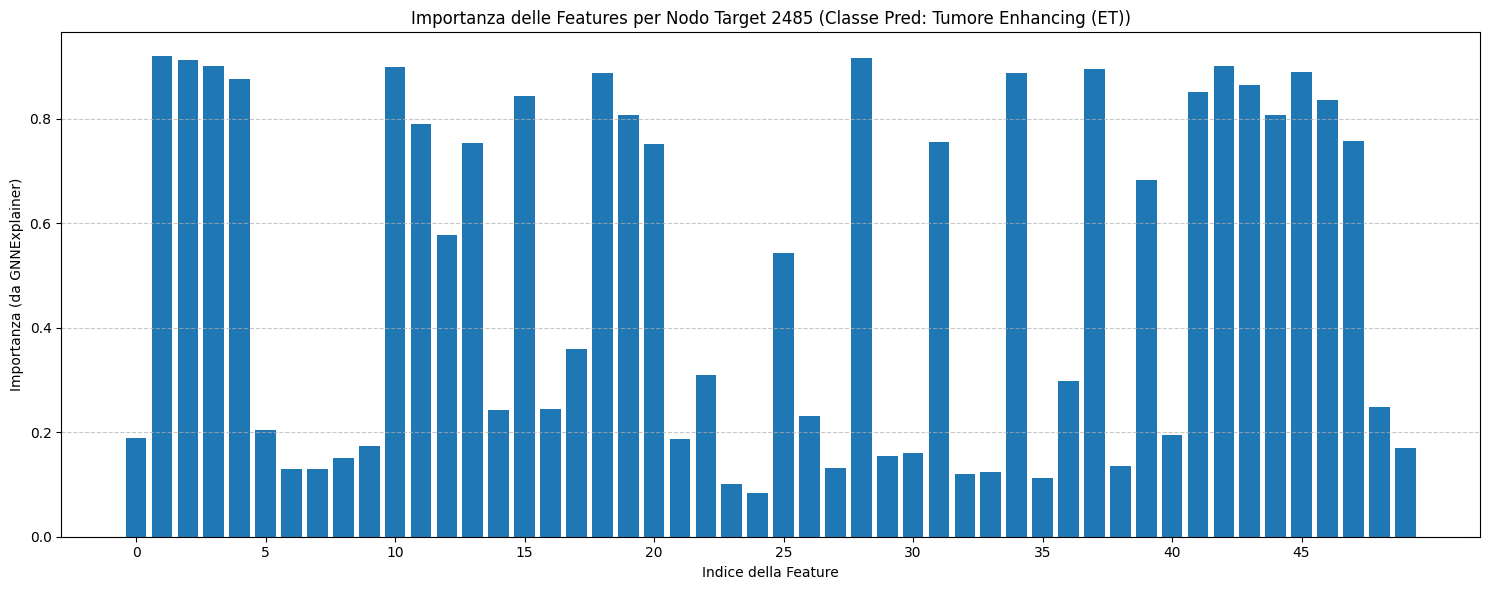


Top 10 features più importanti per il nodo 2485:
  Feature 1: Importanza = 0.9190
  Feature 28: Importanza = 0.9157
  Feature 2: Importanza = 0.9114
  Feature 42: Importanza = 0.9011
  Feature 3: Importanza = 0.8997
  Feature 10: Importanza = 0.8988
  Feature 37: Importanza = 0.8953
  Feature 45: Importanza = 0.8890
  Feature 34: Importanza = 0.8869
  Feature 18: Importanza = 0.8869


In [13]:
# ----- INIZIO NUOVA CELLA PER PLOT FEATURES NODO TARGET -----

if hasattr(explanation, 'node_mask') and explanation.node_mask is not None and \
   explanation.node_mask.shape[0] == data.num_nodes and \
   explanation.node_mask.shape[1] == num_node_features:

    target_node_feature_importances = explanation.node_mask[node_to_explain_index].cpu().detach().numpy()

    print(f"\nVisualizzazione dell'Importanza delle {num_node_features} features per il NODO TARGET {node_to_explain_index}:")

    plt.figure(figsize=(15, 6))
    bar_positions = np.arange(num_node_features)
    plt.bar(bar_positions, target_node_feature_importances)
    plt.xlabel("Indice della Feature")
    plt.xticks(bar_positions[::5]) # Mostra un tick ogni 5 feature per leggibilità
    plt.ylabel("Importanza (da GNNExplainer)")
    plt.title(f"Importanza delle Features per Nodo Target {node_to_explain_index} (Classe Pred: {classes[predicted_labels[node_to_explain_index].item()]})")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Stampa le top K features più importanti
    k_top_features = 10
    # sorted_feature_indices = np.argsort(target_node_feature_importances)[::-1] # Decrescente
    sorted_feature_indices = np.flip(np.argsort(target_node_feature_importances)) # Corretto per evitare problemi di stride
    
    print(f"\nTop {k_top_features} features più importanti per il nodo {node_to_explain_index}:")
    # Se hai una lista `feature_names` di lunghezza `num_node_features`, usala qui!
    # Esempio: feature_names = [f"Feature_{i}" for i in range(num_node_features)]
    for i in range(min(k_top_features, num_node_features)):
        feat_idx = sorted_feature_indices[i]
        importance = target_node_feature_importances[feat_idx]
        # feat_name = feature_names[feat_idx] # Se hai feature_names
        print(f"  Feature {feat_idx}: Importanza = {importance:.4f}")
else:
    print("Formato di 'explanation.node_mask' non come atteso ([data.num_nodes, num_node_features]) per l'analisi delle feature del nodo target.")
    print("Oppure 'explanation.node_mask' è None.")

# ----- FINE NUOVA CELLA PER PLOT FEATURES NODO TARGET -----


--- Analisi degli Archi e Vicini Importanti per il NODO TARGET: 2485 ---

Top 15 archi più importanti CONNESSI al nodo target 2485:
Arco (u, v)     Importanza      Classe Nodo U             Classe Nodo V            
--------------------------------------------------------------------------------
(2375-2485)      0.9413          Tumore Enhancing (ET)     Tumore Enhancing (ET)    
(2430-2485)      0.9340          Tumore Enhancing (ET)     Tumore Enhancing (ET)    
(2360-2485)      0.9315          Tumore Enhancing (ET)     Tumore Enhancing (ET)    
(2376-2485)      0.9288          Tumore Enhancing (ET)     Tumore Enhancing (ET)    
(2574-2485)      0.9160          Edema (ED)                Tumore Enhancing (ET)    
(2222-2485)      0.9085          NCR/NET                   Tumore Enhancing (ET)    
(2435-2485)      0.9078          Sano/Background           Tumore Enhancing (ET)    
(2429-2485)      0.9010          Tumore Enhancing (ET)     Tumore Enhancing (ET)    
(2583-2485)      0.897

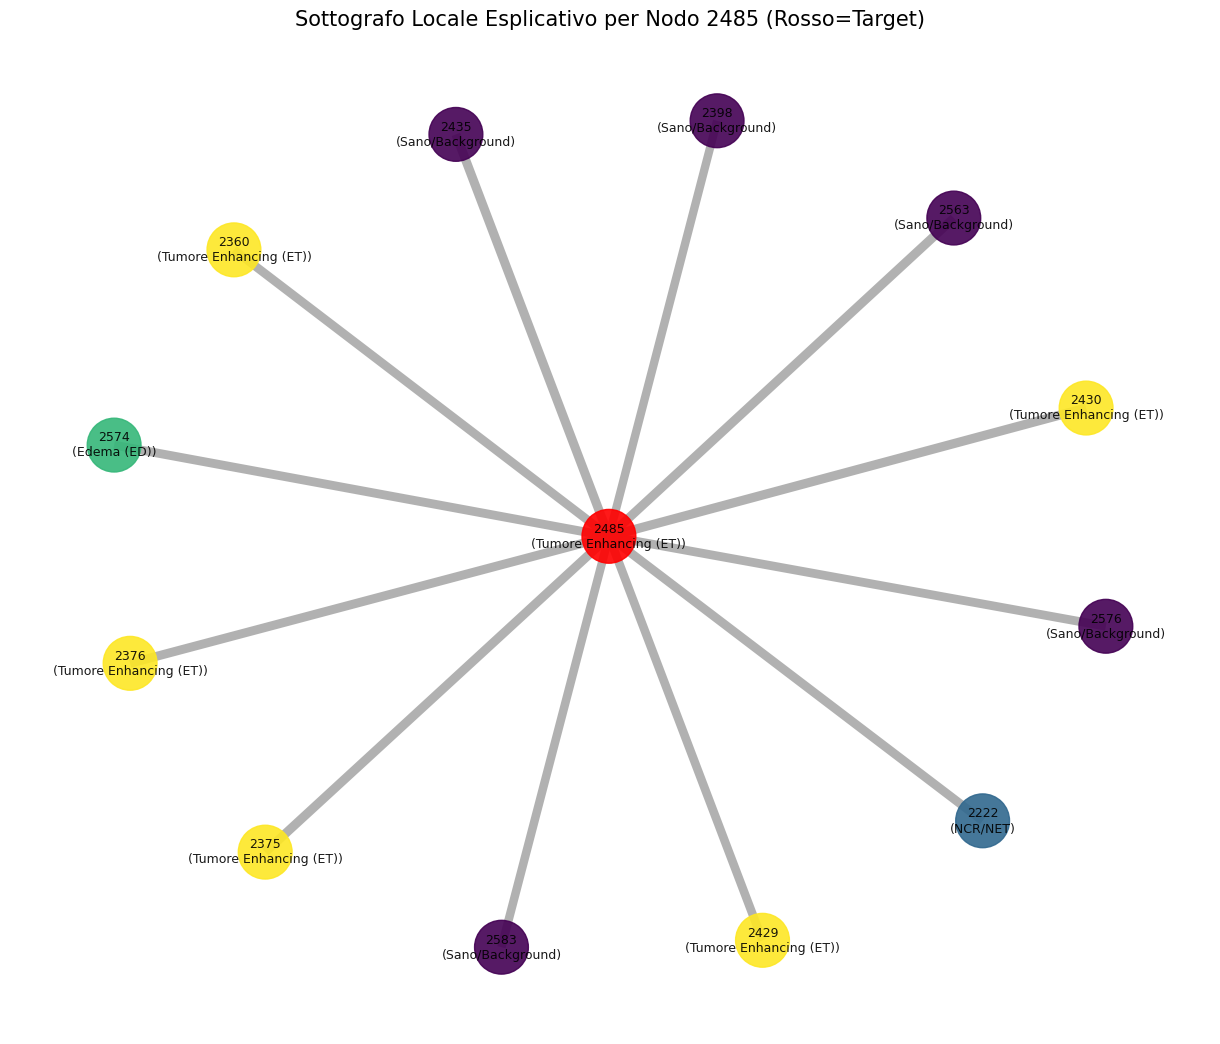

In [14]:
# ----- INIZIO CELLA PER ANALISI ARCHI E VICINI IMPORTANTI (FOCALIZZATA SUL TARGET) -----

if hasattr(explanation, 'edge_mask') and explanation.edge_mask is not None:
    edge_importances_np = explanation.edge_mask.cpu().detach().numpy()
    original_graph_edges_np = data.edge_index.cpu().detach().numpy() # Archi originali del grafo

    if original_graph_edges_np.shape[1] != len(edge_importances_np):
        print(f"ATTENZIONE: Il numero di archi in data.edge_index ({original_graph_edges_np.shape[1]}) "
              f"non corrisponde alla lunghezza di explanation.edge_mask ({len(edge_importances_np)}). L'analisi degli archi non può procedere correttamente.")
    else:
        print(f"\n--- Analisi degli Archi e Vicini Importanti per il NODO TARGET: {node_to_explain_index} ---")
        
        # 1. Estrarre tutti gli archi connessi al nodo target e la loro importanza
        #    (Questa parte è già nel tuo codice precedente e la riutilizziamo)
        connected_edges_info = [] # Lista di tuple: (importance, node_u, node_v)
        for i in range(original_graph_edges_np.shape[1]):
            node_u = int(original_graph_edges_np[0, i])
            node_v = int(original_graph_edges_np[1, i])
            importance = edge_importances_np[i]

            if node_u == node_to_explain_index or node_v == node_to_explain_index:
                connected_edges_info.append((importance, node_u, node_v))
        
        # 2. Ordina gli archi CONNESSI AL TARGET per importanza (decrescente)
        connected_edges_info.sort(key=lambda x: x[0], reverse=True)

        k_top_connected_edges_to_show = 15 # Quanti archi connessi al target mostrare
        
        print(f"\nTop {k_top_connected_edges_to_show} archi più importanti CONNESSI al nodo target {node_to_explain_index}:")
        print(f"{'Arco (u, v)':<15} {'Importanza':<15} {'Classe Nodo U':<25} {'Classe Nodo V':<25}")
        print("-" * 80)

        if not connected_edges_info:
            print(f"Nessun arco con importanza > 0 trovato direttamente connesso al nodo target {node_to_explain_index}.")
        else:
            important_neighbors_of_target = {}
            # Mostra solo i top k_top_connected_edges_to_show archi *che sono connessi al target*
            for i in range(min(k_top_connected_edges_to_show, len(connected_edges_info))):
                importance, node_u, node_v = connected_edges_info[i]
                
                # Assicurati che predicted_labels e classes siano definiti
                class_u_idx = int(predicted_labels[node_u].item())
                class_v_idx = int(predicted_labels[node_v].item())
                class_u_str = classes[class_u_idx]
                class_v_str = classes[class_v_idx]
                
                print(f"({node_u}-{node_v}){'':<5} {importance:<15.4f} {class_u_str:<25} {class_v_str:<25}")

                # Identifica il vicino e aggrega la sua importanza
                neighbor_node_idx = node_v if node_u == node_to_explain_index else node_u
                important_neighbors_of_target[neighbor_node_idx] = important_neighbors_of_target.get(neighbor_node_idx, 0) + importance
            
            if important_neighbors_of_target:
                print(f"\nTop Vicini più influenti per il nodo target {node_to_explain_index} (basato su importanza archi connessi):")
                # Ordina i vicini per importanza aggregata
                sorted_direct_neighbors = sorted(important_neighbors_of_target.items(), key=lambda item: item[1], reverse=True)
                for neighbor_idx_int, total_importance in sorted_direct_neighbors[:10]: # Mostra i top 10 vicini
                    class_neighbor_idx = int(predicted_labels[neighbor_idx_int].item())
                    print(f"  Vicino {neighbor_idx_int} (Classe Predetta: {classes[class_neighbor_idx]}): Importanza Aggreg. Archi = {total_importance:.4f}")
            else:
                print(f"Nessun vicino significativo identificato per il nodo {node_to_explain_index} dai top archi connessi.")

        # ----- Inizio Sezione Visualizzazione NetworkX (OPZIONALE) -----
        if important_neighbors_of_target: # Visualizza solo se ci sono vicini importanti
            try:
                import networkx as nx
                # import matplotlib.pyplot as plt # Assicurati sia importato
                
                plt.figure(figsize=(12, 10))
                vis_graph = nx.Graph()
                
                # Nodi da includere nella visualizzazione: il target e i suoi vicini importanti
                nodes_to_visualize_set = {node_to_explain_index}.union(set(important_neighbors_of_target.keys()))
                
                node_labels_vis = {}
                node_color_list_vis = []
                
                # Palette di colori (definisci 'discrete_colors_for_classes' come suggerito prima)
                cmap_for_plot = plt.get_cmap('viridis')
                discrete_colors_for_classes = [cmap_for_plot(i / (num_classes - 1)) for i in range(num_classes)]

                for node_idx in list(nodes_to_visualize_set):
                    vis_graph.add_node(node_idx)
                    pred_class_idx = int(predicted_labels[node_idx].item())
                    node_labels_vis[node_idx] = f"{node_idx}\n({classes[pred_class_idx]})"
                    if node_idx == node_to_explain_index:
                        node_color_list_vis.append('red')
                    elif 0 <= pred_class_idx < num_classes:
                        node_color_list_vis.append(discrete_colors_for_classes[pred_class_idx])
                    else:
                        node_color_list_vis.append('grey') # Fallback

                # Archi da disegnare: solo quelli tra il nodo target e i suoi vicini importanti
                # (che sono già in `connected_edges_info` e filtrati da `important_neighbors_of_target`)
                edges_to_visualize = []
                edge_weights_visualize = []

                for importance_val, u, v in connected_edges_info: # Itera sugli archi già connessi al target e ordinati
                    if u in nodes_to_visualize_set and v in nodes_to_visualize_set: # Assicura che entrambi siano nel nostro set
                        # Limita al numero di top archi connessi da visualizzare
                        if len(edges_to_visualize) < k_top_connected_edges_to_show :
                            edges_to_visualize.append((u, v))
                            edge_weights_visualize.append(max(0.1, importance_val * 7)) # Scala importanza per spessore
                        else:
                            break 
                
                vis_graph.add_edges_from(edges_to_visualize)

                if vis_graph.number_of_nodes() > 0:
                    pos = nx.spring_layout(vis_graph, k=0.7, iterations=40)
                    nx.draw(vis_graph, pos, labels=node_labels_vis, with_labels=True, 
                            node_color=node_color_list_vis, node_size=1500, font_size=9, 
                            width=edge_weights_visualize, font_color='black', edge_color='darkgrey',
                            alpha=0.9)
                    plt.title(f"Sottografo Locale Esplicativo per Nodo {node_to_explain_index} (Rosso=Target)", fontsize=15)
                    plt.show()
                else:
                    print(f"Sottografo per la visualizzazione è vuoto per il nodo {node_to_explain_index}.")

            except ImportError:
                print("NetworkX non è installato. Salta la visualizzazione del sottografo dei vicini.")
            except Exception as e_vis:
                print(f"Errore durante la visualizzazione del sottografo dei vicini: {e_vis}")
        # ----- Fine Sezione Visualizzazione NetworkX -----
else:
    print("Mancano `explanation.edge_mask` per l'analisi dettagliata degli archi.")

# ----- FINE CELLA PER ANALISI ARCHI E VICINI IMPORTANTI (FOCALIZZATA SUL TARGET) -----


--- ESECUZIONE DI SALIENCY MAPS (Gradiente Semplice) ---
Nodo target selezionato per la spiegazione: Indice 2485
Classe predetta da spiegare: Tumore Enhancing (ET) (Indice: 3)

Visualizzazione della Salienza delle 50 features per il NODO TARGET 2485:


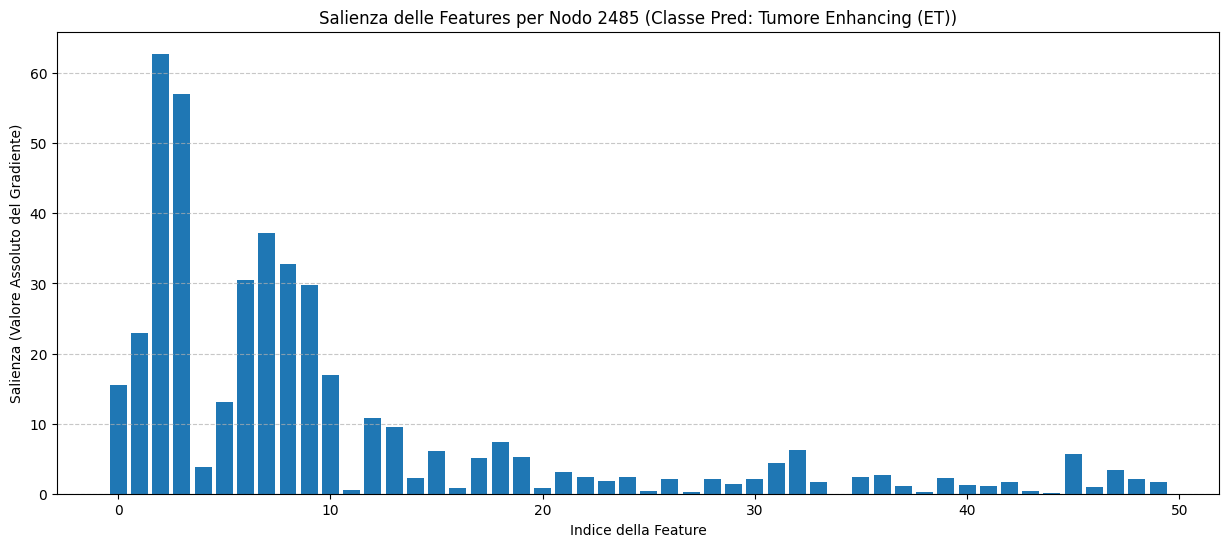


Top 10 features più salienti per il nodo 2485:
  Feature 2: Salienza = 62.7645
  Feature 3: Salienza = 57.0384
  Feature 7: Salienza = 37.2073
  Feature 8: Salienza = 32.7489
  Feature 6: Salienza = 30.4925
  Feature 9: Salienza = 29.7650
  Feature 1: Salienza = 22.9696
  Feature 10: Salienza = 16.9946
  Feature 0: Salienza = 15.4802
  Feature 5: Salienza = 13.1433


In [15]:
# ----- INIZIO NUOVA SEZIONE: SPIEGABILITÀ CON SALIENCY MAPS (IMPLEMENTATO DA ZERO) -----

import torch
import numpy as np
import matplotlib.pyplot as plt

print("\n--- ESECUZIONE DI SALIENCY MAPS (Gradiente Semplice) ---")

# 1. Preparazione: Assicurarsi che l'input richieda il gradiente
# Dobbiamo clonare data.x e impostare `requires_grad=True`
# perché PyTorch calcola i gradienti solo per i tensori che lo richiedono.
x_for_saliency = data.x.clone().requires_grad_(True)
edge_index_long = data.edge_index.type(torch.int64)

# Assicurarsi che il modello sia in modalità valutazione
model.eval()

# 2. Forward pass per ottenere i punteggi (logits)
# Manteniamo il tracciamento del gradiente
logits = model(x_for_saliency, edge_index_long)

# 3. Identificare il target per la spiegazione
# Usiamo lo stesso nodo e la stessa classe predetta delle altre analisi
target_class_idx = predicted_labels[node_to_explain_index].item()
print(f"Nodo target selezionato per la spiegazione: Indice {node_to_explain_index}")
print(f"Classe predetta da spiegare: {classes[target_class_idx]} (Indice: {target_class_idx})")

# Selezioniamo il punteggio specifico del nostro nodo target e della classe target
score_to_explain = logits[node_to_explain_index, target_class_idx]

# 4. Backward pass per calcolare i gradienti
# Questo è il cuore del metodo. Calcoliamo il gradiente dello `score_to_explain`
# rispetto a tutti gli input che hanno `requires_grad=True` (cioè, `x_for_saliency`).
score_to_explain.backward()

# 5. Ottenere e analizzare i gradienti (la mappa di salienza)
# Il gradiente è ora memorizzato in `x_for_saliency.grad`.
# Questo tensore ha la stessa forma di data.x [NumNodi, NumFeature].
# Il gradiente per i nodi non coinvolti nel calcolo per `node_to_explain_index` sarà zero.
saliency_map = x_for_saliency.grad

# A noi interessa solo la salienza delle feature del NODO TARGET
target_node_saliency = saliency_map[node_to_explain_index]

# Usiamo il valore assoluto per l'importanza, poiché ci interessa l'entità dell'impatto.
target_node_saliency_np = target_node_saliency.abs().cpu().detach().numpy()


# 6. Visualizzare i risultati
print(f"\nVisualizzazione della Salienza delle {num_node_features} features per il NODO TARGET {node_to_explain_index}:")

plt.figure(figsize=(15, 6))
bar_positions = np.arange(num_node_features)
plt.bar(bar_positions, target_node_saliency_np)
plt.xlabel("Indice della Feature")
plt.ylabel("Salienza (Valore Assoluto del Gradiente)")
plt.title(f"Salienza delle Features per Nodo {node_to_explain_index} (Classe Pred: {classes[target_class_idx]})")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Stampa le top K features più importanti
k_top_features_saliency = 10
sorted_indices = np.argsort(target_node_saliency_np)[::-1]

print(f"\nTop {k_top_features_saliency} features più salienti per il nodo {node_to_explain_index}:")
for i in range(min(k_top_features_saliency, num_node_features)):
    feat_idx = sorted_indices[i]
    importance = target_node_saliency_np[feat_idx]
    print(f"  Feature {feat_idx}: Salienza = {importance:.4f}")

# ----- FINE SEZIONE SALIENCY MAPS -----

## Analisi di occlusione dei vicini (from scratch)


--- ANALISI DI OCCLUSIONE PER I VICINI DEL NODO TARGET: 2485 ---
Probabilità originale per la classe 'Tumore Enhancing (ET)': 0.6520
Il nodo 2485 ha 12 vicini. Inizio analisi...
Analisi completata in 7.90 secondi.


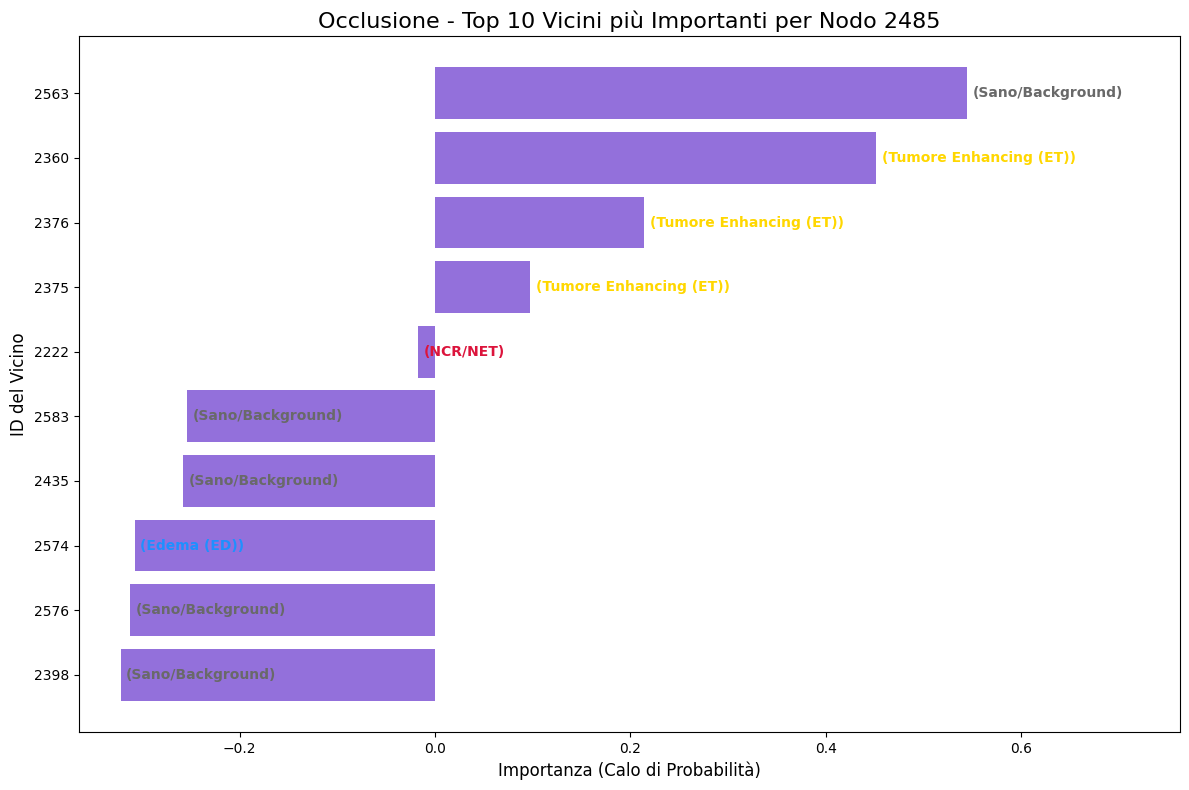

In [20]:
# cella 15
# ======================================================================
# ==========>   METODO DI SPIEGABILITÀ 3: ANALISI DI OCCLUSIONE   <==========
# ======================================================================

import torch
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

print(f"\n--- ANALISI DI OCCLUSIONE PER I VICINI DEL NODO TARGET: {node_to_explain_index} ---")

# 1. Ottenere la predizione e la probabilità originali
model.eval()
with torch.no_grad():
    original_logits = model(data.x, data.edge_index.type(torch.int64))
    original_probs = F.softmax(original_logits, dim=1)
    target_class_idx = predicted_labels[node_to_explain_index].item()
    original_prob_for_target_node = original_probs[node_to_explain_index, target_class_idx].item()
    
print(f"Probabilità originale per la classe '{classes[target_class_idx]}': {original_prob_for_target_node:.4f}")

# 2. Trovare tutti i vicini del nodo target
edge_index_np = data.edge_index.cpu().numpy()
source_neighbors = edge_index_np[1, edge_index_np[0, :] == node_to_explain_index]
destination_neighbors = edge_index_np[0, edge_index_np[1, :] == node_to_explain_index]
all_neighbors = np.unique(np.concatenate([source_neighbors, destination_neighbors]))

if len(all_neighbors) == 0:
    print(f"Il nodo {node_to_explain_index} non ha vicini. L'analisi di occlusione non può procedere.")
else:
    print(f"Il nodo {node_to_explain_index} ha {len(all_neighbors)} vicini. Inizio analisi...")
    start_time = time.time()

    # 3. Ciclo di occlusione
    neighbor_importance = {}
    for neighbor_to_occlude in all_neighbors:
        mask_uv = (data.edge_index[0] == node_to_explain_index) & (data.edge_index[1] == neighbor_to_occlude)
        mask_vu = (data.edge_index[0] == neighbor_to_occlude) & (data.edge_index[1] == node_to_explain_index)
        perturbed_edge_index = data.edge_index[:, ~(mask_uv | mask_vu)]
        
        with torch.no_grad():
            perturbed_probs = F.softmax(model(data.x, perturbed_edge_index.type(torch.int64)), dim=1)
            new_prob = perturbed_probs[node_to_explain_index, target_class_idx].item()
        
        importance_score = original_prob_for_target_node - new_prob
        neighbor_importance[int(neighbor_to_occlude)] = importance_score

    elapsed_time = time.time() - start_time
    print(f"Analisi completata in {elapsed_time:.2f} secondi.")
    
    # 4. Preparazione per la visualizzazione
    sorted_important_neighbors = sorted(neighbor_importance.items(), key=lambda item: item[1], reverse=True)
    k_top_neighbors = 10
    top_k_list = sorted_important_neighbors[:k_top_neighbors]

    # --- 5. VISUALIZZAZIONE FINALE ---
    if top_k_list:
        neighbor_ids = [str(n[0]) for n in top_k_list]
        importances = [n[1] for n in top_k_list]
        
        # Dizionario dei colori definito localmente
        class_colors = {0: '#696969', 1: '#DC143C', 2: '#1E90FF', 3: '#FFD700'} # Grigio Scuro, Rosso, Blu, Oro

        fig, ax = plt.subplots(figsize=(12, 8))
        bars = ax.barh(neighbor_ids, importances, color='#9370DB') # Viola Medio
        
        ax.invert_yaxis()
        ax.set_xlabel("Importanza (Calo di Probabilità)", fontsize=12)
        ax.set_ylabel("ID del Vicino", fontsize=12)
        ax.set_title(f"Occlusione - Top {k_top_neighbors} Vicini più Importanti per Nodo {node_to_explain_index}", fontsize=16)
        
        # Calcola il limite destro per fare spazio alle etichette
        max_importance = max(importances) if importances else 0
        # Aggiungi un margine del 40% se l'importanza è > 0, altrimenti imposta un margine fisso
        padding = max_importance * 0.4 if max_importance > 0.0001 else 0.1
        ax.set_xlim(right=max_importance + padding)

        # Aggiungi etichette con la classe del vicino
        for bar, (node_id, imp) in zip(bars, top_k_list):
            class_idx = predicted_labels[node_id].item()
            class_str = classes[class_idx]
            
            # Posiziona il testo in modo leggibile
            text_x_pos = bar.get_width() + max(importances) * 0.01 if max(importances) > 0.0001 else 0.001
            
            ax.text(text_x_pos, bar.get_y() + bar.get_height()/2.0, 
                    f'({class_str})', 
                    va='center', 
                    ha='left', 
                    color=class_colors.get(class_idx, 'black'),
                    fontsize=10,
                    fontweight='bold')
            
        plt.tight_layout()
        plt.show()

# ----- FINE SEZIONE ANALISI DI OCCLUSIONE -----

## Saliency Maps (from scratch)


--- ESECUZIONE DI SALIENCY MAPS (Gradiente Semplice) ---
Nodo target selezionato: Indice 2485
Classe predetta da spiegare: Tumore Enhancing (ET) (Indice: 3)


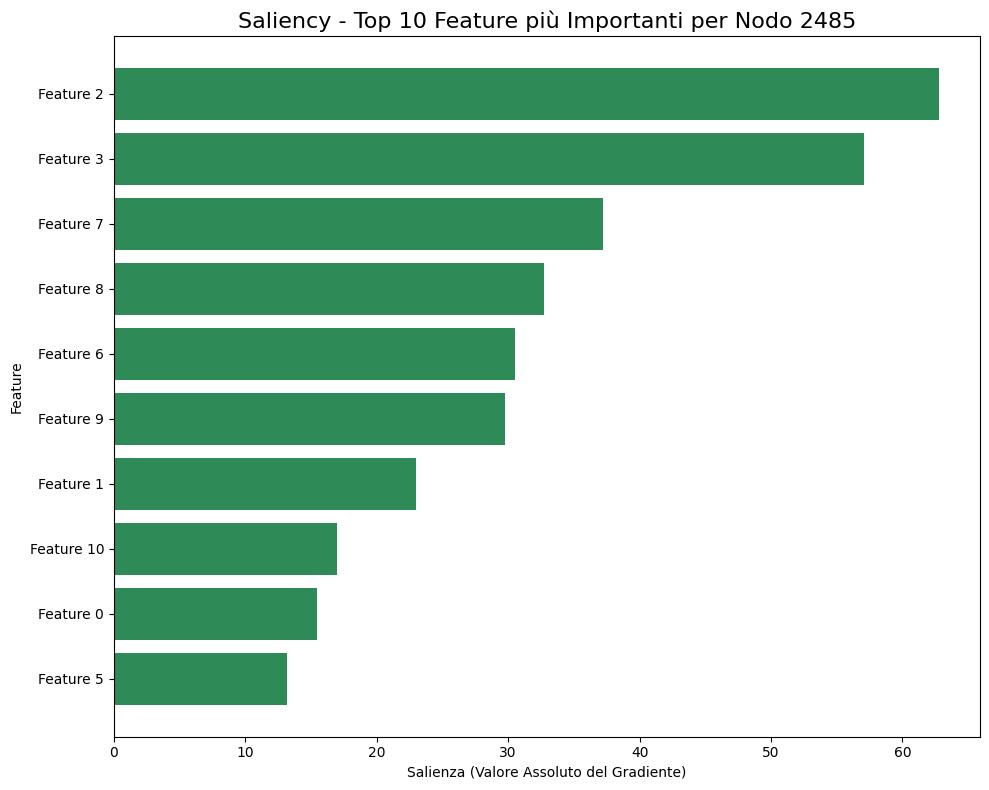


Top 10 features più salienti per il nodo 2485:
  - Feature 2: Salienza = 62.7645
  - Feature 3: Salienza = 57.0384
  - Feature 7: Salienza = 37.2073
  - Feature 8: Salienza = 32.7489
  - Feature 6: Salienza = 30.4925
  - Feature 9: Salienza = 29.7650
  - Feature 1: Salienza = 22.9696
  - Feature 10: Salienza = 16.9946
  - Feature 0: Salienza = 15.4802
  - Feature 5: Salienza = 13.1433


In [17]:
# ======================================================================
# ==========>   METODO DI SPIEGABILITÀ 2: SALIENCY MAPS   <==========
# ======================================================================
import matplotlib.patches as mpatches

print("\n--- ESECUZIONE DI SALIENCY MAPS (Gradiente Semplice) ---")

# 1. Preparazione: Assicurarsi che l'input richieda il gradiente.
# PyTorch calcola i gradienti solo per i tensori che hanno `requires_grad=True`.
# Cloniamo `data.x` per non modificare il tensore originale.
x_for_saliency = data.x.clone().requires_grad_(True)
edge_index_long = data.edge_index.type(torch.int64)

# Assicurarsi che il modello sia in modalità valutazione
model.eval()

# Azzeriamo eventuali gradienti pre-esistenti
if x_for_saliency.grad is not None:
    x_for_saliency.grad.zero_()

# 2. Forward pass per ottenere i punteggi (logits)
# Manteniamo il tracciamento del gradiente
logits = model(x_for_saliency, edge_index_long)

# 3. Identificare il target per la spiegazione
# Usiamo lo stesso nodo e la stessa classe predetta dalle altre analisi
pred_class_idx = predicted_labels[node_to_explain_index].item()
print(f"Nodo target selezionato: Indice {node_to_explain_index}")
print(f"Classe predetta da spiegare: {classes[pred_class_idx]} (Indice: {pred_class_idx})")

# Selezioniamo il punteggio specifico del nostro nodo target e della classe target
score_to_explain = logits[node_to_explain_index, pred_class_idx]

# 4. Backward pass per calcolare i gradienti
# Questo è il cuore del metodo. Calcoliamo il gradiente dello `score_to_explain`
# rispetto a `x_for_saliency`.
score_to_explain.backward()

# 5. Ottenere e analizzare i gradienti (la mappa di salienza)
# Il gradiente è ora memorizzato in `x_for_saliency.grad`.
# A noi interessa solo la salienza delle feature del NODO TARGET
target_node_saliency = x_for_saliency.grad[node_to_explain_index]

# Usiamo il valore assoluto per l'importanza, poiché ci interessa l'entità dell'impatto (sia positivo che negativo).
target_node_saliency_np = target_node_saliency.abs().cpu().detach().numpy()

# --- 6. VISUALIZZAZIONE MIGLIORATA ---
k_top_features = 10
sorted_indices = np.argsort(target_node_saliency_np)[-k_top_features:]

# Nomi delle feature (puoi personalizzarli se li conosci)
feature_names = [f"Feature {i}" for i in range(num_node_features)]
top_feature_names = [feature_names[i] for i in sorted_indices]
top_feature_importances = target_node_saliency_np[sorted_indices]

plt.figure(figsize=(10, 8))
bars = plt.barh(np.arange(len(top_feature_names)), top_feature_importances, color='#2E8B57') # Verde Foresta
plt.yticks(np.arange(len(top_feature_names)), top_feature_names)
plt.xlabel("Salienza (Valore Assoluto del Gradiente)")
plt.ylabel("Feature")
plt.title(f"Saliency - Top {k_top_features} Feature più Importanti per Nodo {node_to_explain_index}", fontsize=16)
plt.tight_layout()
plt.show()

# Stampa testuale dei top K per completezza
print(f"\nTop {k_top_features} features più salienti per il nodo {node_to_explain_index}:")
for i in reversed(range(len(top_feature_names))): # Stampa dal più importante
    idx = sorted_indices[i]
    imp = target_node_saliency_np[idx]
    print(f"  - {feature_names[idx]}: Salienza = {imp:.4f}")

# ----- FINE SEZIONE SALIENCY MAPS -----